In [1]:
from typing import List

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.MolStandardize import rdMolStandardize
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from actlearn.select import kriging_believer, predict_posterior

In [2]:
params = rdMolStandardize.CleanupParameters()
params.maxTautomers = 100
params.maxTransforms = 100
te = rdMolStandardize.TautomerEnumerator(params)


def inchi_to_smiles(inchi):
    if not inchi:
        return None
    mol = Chem.MolFromInchi(inchi)
    if not mol:
        return None
    return Chem.MolToSmiles(te.Canonicalize(mol))


def add_inchikeys(inrep):
    if type(inrep) == str:
        mol = Chem.MolFromSmiles(inrep)
    else:
        mol = inrep
    try:
        inchikey = inchi.MolToInchiKey(mol, options="/FixedH")
    except:
        inchikey = None
    return inchikey

In [3]:
def rxn_dfp(rsmi):
    r, _, p = rsmi.split('>')
    rfp = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(r), 4, useChirality=True)
    pfp = AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(p), 4, useChirality=True)
    return np.array(pfp) - np.array(rfp)

In [73]:
domain = pd.read_csv("../data/brbr_reaction_domain_batch4.csv")

In [74]:
# load DFT features
alkyl = pd.read_csv('../data/BrBr_dft_selectfeatures_alkylBr.csv')
aryl = pd.read_csv('../data/BrBr_dft_selectfeatures_arylBr.csv')
alkyl['smiles'] = alkyl['smiles'].apply(lambda x: Chem.CanonSmiles(x, False))
aryl['core_smiles'] = aryl['core_smiles'].apply(lambda x: Chem.CanonSmiles(x, False))
alkyl = alkyl.groupby('smiles').mean(numeric_only=True)
aryl = aryl.groupby('core_smiles').mean(numeric_only=True)

aryl2 = pd.read_csv("../data/BrBr_dft_selectfeatures_arylBr_cores9t12.csv")
aryl2['core_smiles'] = aryl2['core_smiles'].apply(lambda x: Chem.CanonSmiles(x, False))
aryl2 = aryl2.groupby('core_smiles').mean(numeric_only=True)
domain2 = pd.read_csv("../data/BrBr_products_cores9t12.csv")

In [75]:
domain2['smiles_aryl'] = domain2['smiles_aryl'].apply(lambda x: Chem.CanonSmiles(x, False))

In [76]:
domain2['smiles_alkyl'] = domain2['smiles_alkyl'].apply(lambda x: Chem.CanonSmiles(x, False))

In [77]:
aryl2 = aryl2[[c for c in aryl2.columns if c in aryl.columns]]

In [78]:
# add features to domain
domain_dfp = np.vstack(joblib.Parallel(n_jobs=32, verbose=1)(
    joblib.delayed(rxn_dfp)(rsmi) for rsmi in domain['rsmi_mapped']
))
domain_core_f = aryl.loc[domain['smiles_aryl']].values
domain_bb_f = alkyl.loc[domain['smiles_alkyl']].values
# merging alkyl and aryl DFT features with reaction fingerprints
domain_f = np.hstack([domain_dfp, domain_core_f, domain_bb_f])
f_cols = [f'f_{idx}' for idx in range(domain_f.shape[1])]
# adding features to domain
domain.loc[:, f_cols] = domain_f

[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:   40.3s
[Parallel(n_jobs=32)]: Done 840 tasks      | elapsed:   41.1s
[Parallel(n_jobs=32)]: Done 2240 tasks      | elapsed:   42.9s
[Parallel(n_jobs=32)]: Done 4040 tasks      | elapsed:   45.2s
[Parallel(n_jobs=32)]: Done 6240 tasks      | elapsed:   47.5s
[Parallel(n_jobs=32)]: Done 8840 tasks      | elapsed:   50.4s
[Parallel(n_jobs=32)]: Done 11840 tasks      | elapsed:   54.1s
[Parallel(n_jobs=32)]: Done 15240 tasks      | elapsed:   58.7s
[Parallel(n_jobs=32)]: Done 19040 tasks      | elapsed:  1.1min
[Parallel(n_jobs=32)]: Done 22208 out of 22208 | elapsed:  1.1min finished


In [79]:
# add features to domain
domain2_dfp = np.vstack(joblib.Parallel(n_jobs=32, verbose=1)(
    joblib.delayed(rxn_dfp)(rsmi) for rsmi in domain2['reaction_smarts']
))

[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 208 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 1032 tasks      | elapsed:    1.6s
[Parallel(n_jobs=32)]: Done 3712 tasks      | elapsed:    3.0s
[Parallel(n_jobs=32)]: Done 7312 tasks      | elapsed:    5.0s
[Parallel(n_jobs=32)]: Done 10984 tasks      | elapsed:    7.6s
[Parallel(n_jobs=32)]: Done 11104 out of 11104 | elapsed:    7.8s finished


In [80]:
domain2_core_f = aryl2.loc[domain2['smiles_aryl']].values
domain2_bb_f = alkyl.loc[domain2['smiles_alkyl']].values
# merging alkyl and aryl DFT features with reaction fingerprints
domain2_f = np.hstack([domain2_dfp, domain2_core_f, domain2_bb_f])
f_cols = [f'f_{idx}' for idx in range(domain2_f.shape[1])]
# adding features to domain
domain2.loc[:, f_cols] = domain2_f

In [81]:
task_name = "CAD Percent Yield (%)"
print(domain.shape)
results = domain[(domain[task_name] != 'no signal') & (domain[task_name] != 'INCONCLUSIVE') & (domain[task_name] != 'co eluted')].dropna(subset=[task_name])
print(results.shape)

(22208, 2145)
(866, 2145)


In [82]:
results = results.reset_index(drop=True)
results[task_name] = pd.to_numeric(results[task_name], errors="coerce")
results.dropna(subset=task_name, inplace=True)
print(results.shape)

(864, 2145)


In [83]:
domain["selection"].value_counts()

selection
active_learning_3    96
random_4             96
active_learning_2    96
active_learning_1    96
random_1             95
random_3             93
test_2               91
initial_diverse      88
random_2             84
test_1               70
Name: count, dtype: int64

In [84]:
sm_test_alkyl = list(domain[domain["category"] == "test"]["smiles_alkyl"].unique())

In [85]:
domain2["category"] = domain2["smiles_alkyl"].isin(sm_test_alkyl)
domain2["category"] = domain2["category"].map({True:"test", False:None})
domain2["selection"] = None
domain2["category"].value_counts()

/tmp/ipykernel_52595/700395394.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  domain2["category"] = domain2["smiles_alkyl"].isin(sm_test_alkyl)
/tmp/ipykernel_52595/700395394.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  domain2["selection"] = None


category
test    200
Name: count, dtype: int64

In [86]:
# remove anything reserved for test set or already submitted for testing (including example with no data)
# search space this time is with the new cores
domain2 = domain2[(domain2["category"] != "test") & (domain2["selection"].isna())]

In [87]:
al_batches = ["initial_diverse", "active_learning_1", "active_learning_2", "active_learning_3"]
results = results[results["selection"].isin(al_batches)]
print(results.shape)
results["selection"].value_counts()

(341, 2145)


selection
active_learning_2    96
active_learning_3    86
initial_diverse      83
active_learning_1    76
Name: count, dtype: int64

In [88]:
experiments = kriging_believer(
    domain=domain2,
    results=results,
    x_cols=f_cols,
    batch_size=30,
    id_column='smiles',
    target_column=task_name,
    bb_smiles_column='smiles_alkyl',
    output_dir='iterations/batch_4'
)

100%|██████████| 30/30 [01:42<00:00,  3.41s/it]


In [89]:
from rdkit.Chem import PandasTools

In [90]:
df = PandasTools.LoadSDF('iterations/batch_4/selections.sdf')

Failed to patch pandas - unable to change molecule rendering


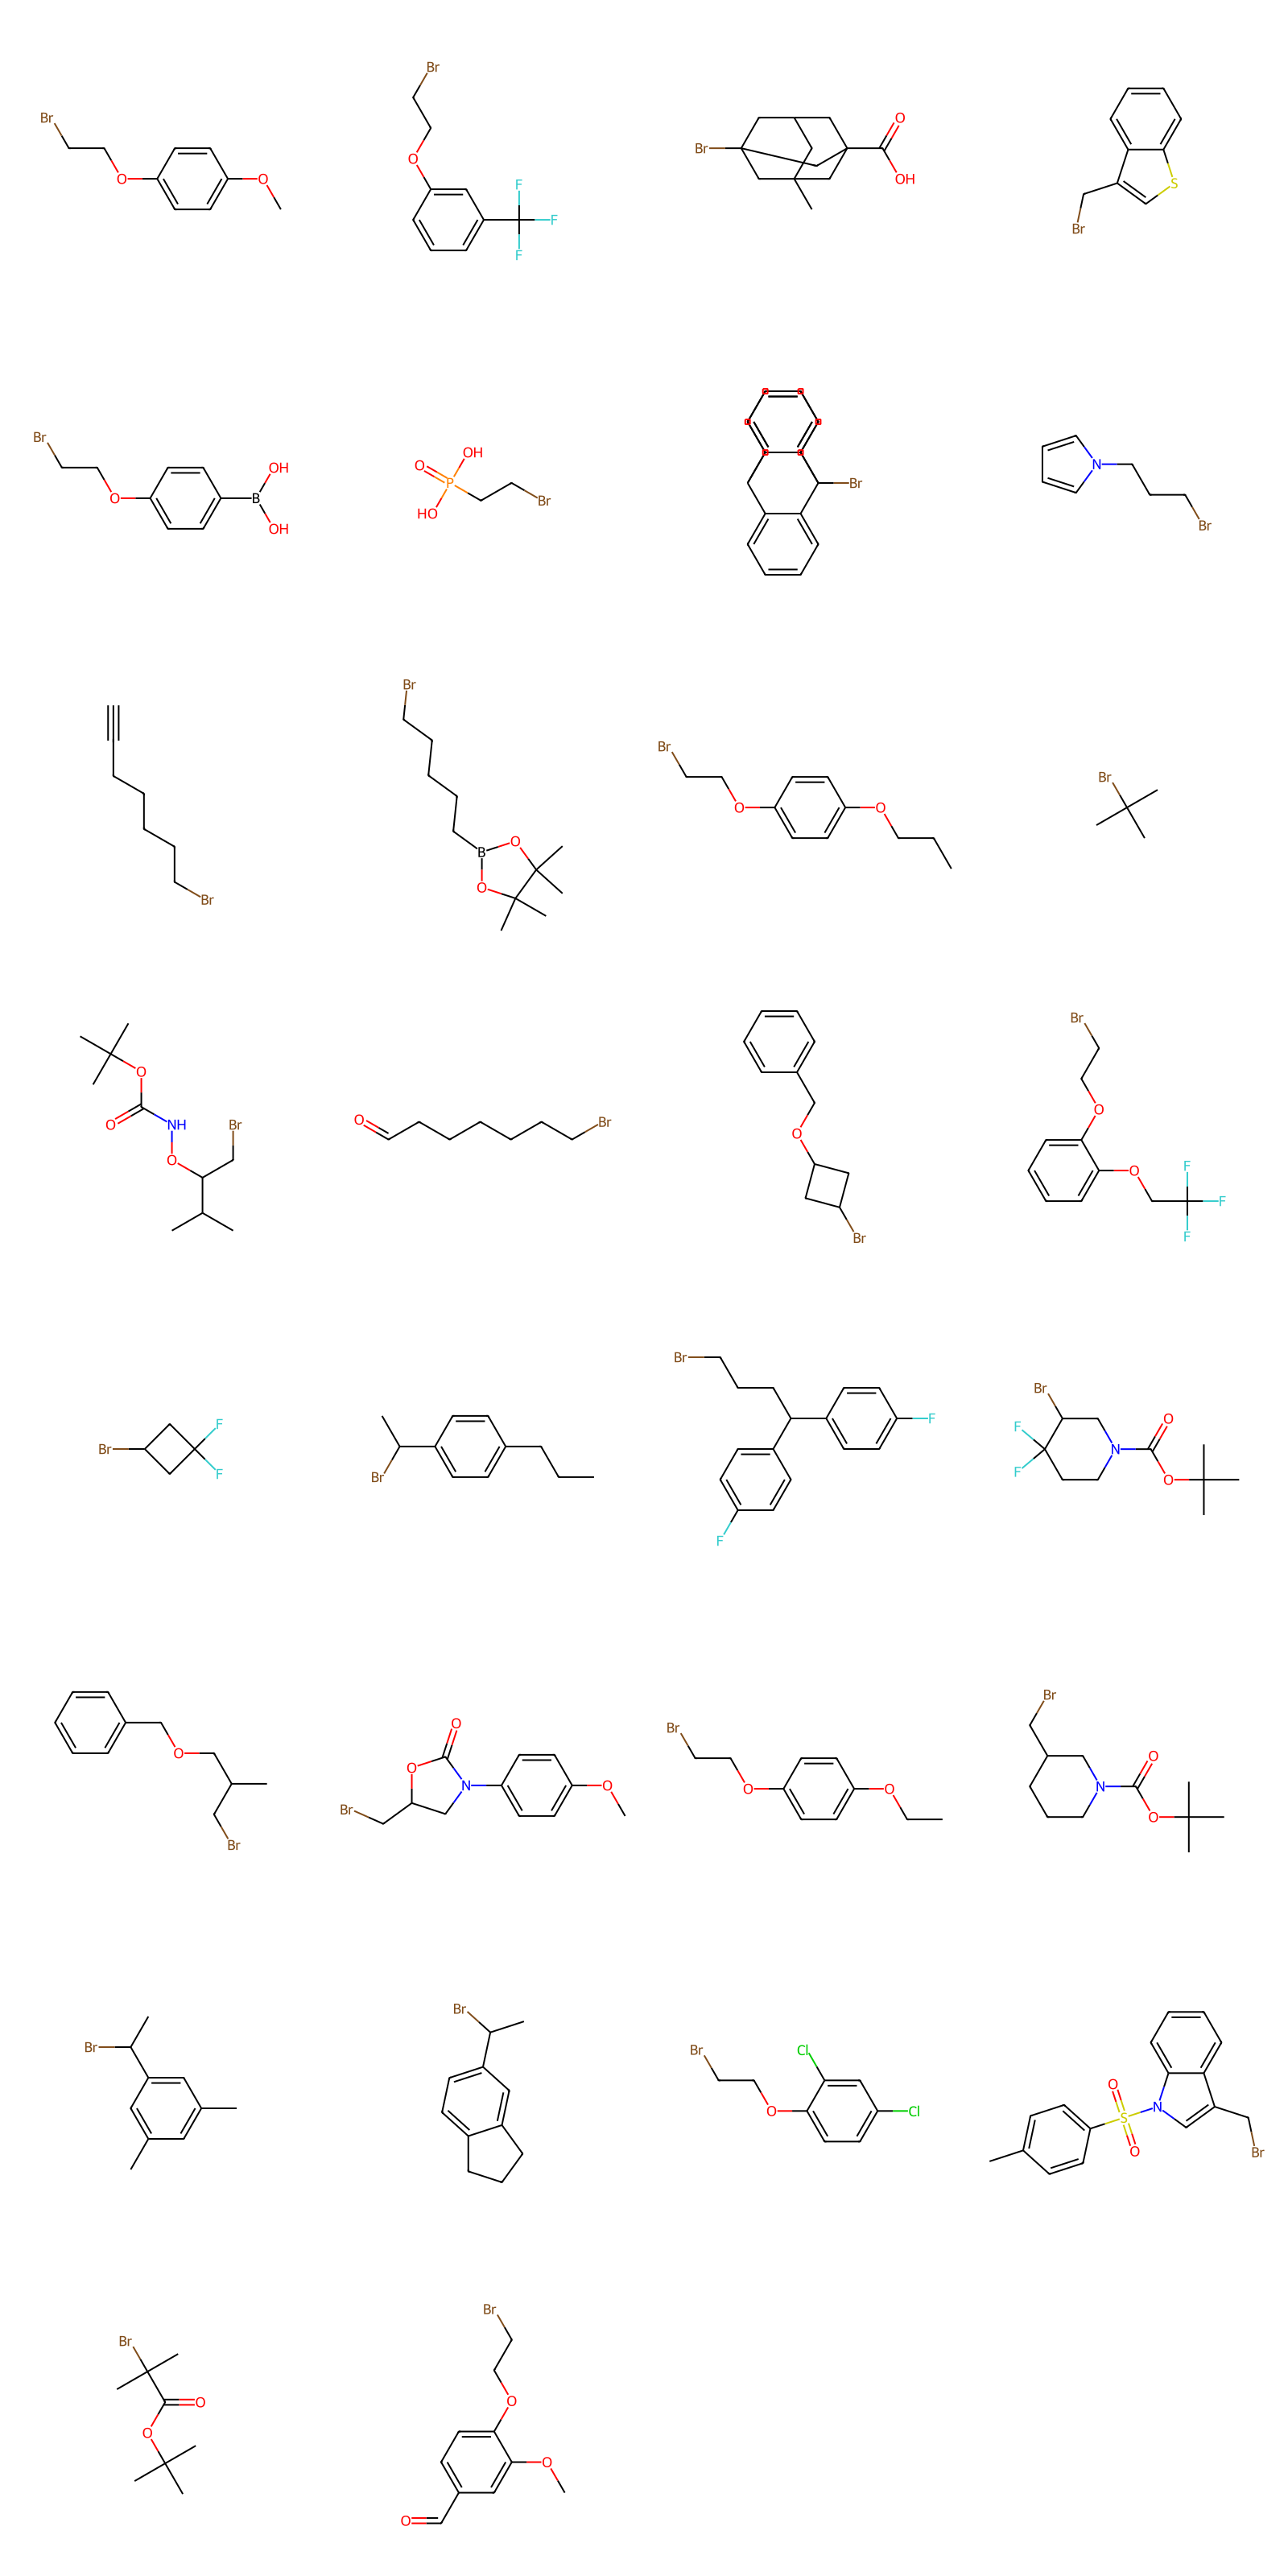

In [91]:
Chem.Draw.MolsToGridImage(df["ROMol"], subImgSize=(400,400), molsPerRow=4)